# 00 data preparation Notebook

This notebook implements the analysis for the 00 data preparation stage of the Fantasy Football Analysis project.

In [1]:
"""
Data Preparation for Fantasy Football Analysis

This script handles the initial data loading, cleaning, and preprocessing steps for the Fantasy Football Analysis project.
It includes:
1. Loading raw data files
2. Standardizing team and player names
3. Cleaning and preprocessing data
4. Creating a master player dataset
5. Calculating fantasy points in half-PPR format
6. Saving processed datasets for further analysis
"""


'\nData Preparation for Fantasy Football Analysis\n\nThis script handles the initial data loading, cleaning, and preprocessing steps for the Fantasy Football Analysis project.\nIt includes:\n1. Loading raw data files\n2. Standardizing team and player names\n3. Cleaning and preprocessing data\n4. Creating a master player dataset\n5. Calculating fantasy points in half-PPR format\n6. Saving processed datasets for further analysis\n'

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import yaml
import logging
from pathlib import Path


notebook_path = os.getcwd()  # Gets the current working directory
sys.path.append(os.path.dirname(notebook_path))  # Adds parent directory to path

# Import project modules
from src.data.data_loader import load_config, load_csv_data, load_all_data
from src.data.data_processor import (
    standardize_team_names, 
    filter_season_data, 
    create_master_player_dataset,
    calculate_half_ppr_points,
    save_processed_data
)
from src.utils.validation import validate_dataframe

In [3]:
# TODO: Implement 00 data preparation analysis

In [4]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_configuration():
    """Load configuration and extract important paths and settings."""
    # Load configuration
    config = load_config()
    logger.info("Configuration loaded")
    
    # Print configuration details
    for section, settings in config.items():
        logger.info(f"\n{section.upper()}:")
        if isinstance(settings, dict):
            for key, value in settings.items():
                logger.info(f"  {key}: {value}")
        else:
            logger.info(f"  {settings}")
    
    # Extract important paths
    raw_data_path = config['data_paths']['raw_data']
    processed_data_path = config['data_paths']['processed_data']
    season = config['analysis']['season']
    
    logger.info(f"\nAnalyzing season: {season}")
    
    return config, raw_data_path, processed_data_path, season

In [5]:
def check_data_files(raw_data_path):
    """Define and check if expected data files exist in the raw data directory."""
    # Define expected data files
    expected_files = {
        'preseason_rankings': 'F00  2024 PreSeason Rankings.csv',
        'season_data': 'F01  2023 2024 Season Player Data.csv',
        'passing_data': 'F02  2023 2024 pff_passing_summary.csv',
        'line_data': 'F03  2023 2024 pff_line_pass_blocking_efficiency.csv',
        'receiving_data': 'F04  2023 2024 pff_receiving_summary.csv',
        'rushing_data': 'F05  2023 2024 pff_rushing_summary.csv',
        'team_stats': 'F06  2024 2023 Team Stats.csv'
    }
    
    # Check if files exist
    missing_files = []
    for key, filename in expected_files.items():
        file_path = os.path.join(raw_data_path, filename)
        if not os.path.exists(file_path):
            missing_files.append(filename)
            logger.warning(f"⚠️ Missing file: {filename}")
        else:
            logger.info(f"✅ Found file: {filename}")
    
    if missing_files:
        logger.warning(f"\n❌ {len(missing_files)} file(s) missing. Please add them to the {raw_data_path} directory.")
        logger.info("Continuing with available files...")
    else:
        logger.info(f"\n✅ All expected files found in {raw_data_path}")
    
    return expected_files


In [6]:
def load_and_examine_data(config):
    """Load all data files and examine their structure."""
    # Load all data files
    logger.info("Loading data files...")
    data_dict = load_all_data(config)
    
    # Print summary of loaded data
    logger.info("\nData summary:")
    for key, df in data_dict.items():
        logger.info(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # Validate dataframes
    for key, df in data_dict.items():
        validate_dataframe(df, key)
    
    return data_dict

In [7]:
def examine_preseason_rankings(data_dict):
    """Examine the preseason rankings dataset."""
    if 'preseason_rankings' not in data_dict:
        logger.warning("Preseason rankings data not available")
        return
    
    logger.info("Examining preseason rankings data...")
    rankings_df = data_dict['preseason_rankings']
    
    logger.info("Preseason Rankings Sample:")
    print(rankings_df.head())
    logger.info(f"Columns: {rankings_df.columns.tolist()}")
    
    # Show positions and teams
    logger.info(f"\nPositions: {rankings_df['Position'].unique().tolist()}")
    logger.info(f"Number of teams: {rankings_df['Team'].nunique()}")
    
    # Show ADP distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=rankings_df, x='ADP', hue='Position', bins=20, multiple='stack')
    plt.title('ADP Distribution by Position')
    plt.savefig('outputs/figures/adp_distribution.png')
    plt.close()
    
    logger.info("ADP distribution histogram saved to outputs/figures/adp_distribution.png")


In [8]:
def examine_season_data(data_dict, season):
    """Examine the season player data."""
    if 'season_data' not in data_dict:
        logger.warning("Season data not available")
        return
    
    logger.info("Examining season data...")
    season_data = data_dict['season_data']
    
    logger.info("Season Data Sample:")
    print(season_data.head())
    
    # Show seasons included
    seasons = season_data['Season'].unique()
    logger.info(f"Seasons included: {seasons}")
    
    # Count players by position
    position_counts = season_data.groupby(['Season', 'FantPos']).size().unstack()
    logger.info("\nPlayers by position and season:")
    print(position_counts)
    
    # Show top performers by position for the target season
    season_df = season_data[season_data['Season'] == season]
    
    plt.figure(figsize=(12, 8))
    for i, pos in enumerate(['QB', 'RB', 'WR', 'TE']):
        plt.subplot(2, 2, i+1)
        pos_df = season_df[season_df['FantPos'] == pos].sort_values('TD', ascending=False).head(10)
        sns.barplot(data=pos_df, x='Player', y='TD')
        plt.title(f'Top 10 {pos}s by Touchdowns')
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('outputs/figures/top_td_scorers.png')
    plt.close()
    
    logger.info("Top TD scorers chart saved to outputs/figures/top_td_scorers.png")


In [9]:
def examine_passing_data(data_dict, season):
    """Examine the passing data."""
    if 'passing_data' not in data_dict:
        logger.warning("Passing data not available")
        return
    
    logger.info("Examining passing data...")
    passing_data = data_dict['passing_data']
    
    logger.info("Passing Data Sample:")
    print(passing_data.head())
    
    # Show seasons included
    passing_seasons = passing_data['season'].unique()
    logger.info(f"Seasons included: {passing_seasons}")
    
    # Show QBs by team
    qb_by_team = passing_data[passing_data['season'] == season].groupby('team_name').size()
    logger.info(f"\nNumber of QBs per team (season {season}):")
    print(qb_by_team.sort_values(ascending=False))

In [10]:
def examine_team_stats(data_dict, season):
    """Examine the team stats data."""
    if 'team_stats' not in data_dict:
        logger.warning("Team stats not available")
        return
    
    logger.info("Examining team stats...")
    team_stats = data_dict['team_stats']
    
    logger.info("Team Stats Sample:")
    print(team_stats.head())
    
    # Show seasons included
    team_seasons = team_stats['Season'].unique()
    logger.info(f"Seasons included: {team_seasons}")
    
    # Show teams with highest points scored
    top_scoring_teams = team_stats[team_stats['Season'] == season].sort_values('PF', ascending=False).head(10)
    logger.info("\nTop 10 scoring teams:")
    print(top_scoring_teams[['Team (Full)', 'PF', 'Passing Yds', 'Rushing Yds']])
    
    # Visualize team offensive stats
    plt.figure(figsize=(12, 6))
    season_teams = team_stats[team_stats['Season'] == season]
    plt.scatter(season_teams['Passing Yds'], season_teams['Rushing Yds'], s=season_teams['PF']/2, alpha=0.7)
    plt.xlabel('Passing Yards')
    plt.ylabel('Rushing Yards')
    plt.title(f'Team Offensive Profile (Size = Points Scored, Season {season})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('outputs/figures/team_offensive_profile.png')
    plt.close()
    
    logger.info("Team offensive profile chart saved to outputs/figures/team_offensive_profile.png")


In [11]:
def standardize_team_names_across_datasets(data_dict):
    """Standardize team names across all datasets."""
    # Check team name variations
    logger.info("Team name variations across datasets:")
    team_variations = {}
    
    for key, df in data_dict.items():
        if 'Team' in df.columns:
            # Convert to string and filter out NaN values
            teams = df['Team'].astype(str).replace('nan', '').replace('0', '').unique()
            teams = [t for t in teams if t]  # Remove empty strings
            team_variations[key] = teams
        elif 'team_name' in df.columns:
            # Convert to string and filter out NaN values
            teams = df['team_name'].astype(str).replace('nan', '').replace('0', '').unique()
            teams = [t for t in teams if t]  # Remove empty strings
            team_variations[key] = teams
    
    for dataset, teams in team_variations.items():
        logger.info(f"\n{dataset}: {sorted(teams)}")
    
    # Standardize team names
    logger.info("\nStandardizing team names...")
    data_dict = standardize_team_names(data_dict)
    
    # Verify standardization
    logger.info("Verifying team name standardization:")
    for key, df in data_dict.items():
        if 'Team_std' in df.columns:
            # Convert to string and filter out NaN values
            std_teams = df['Team_std'].astype(str).replace('nan', '').replace('0', '').unique()
            std_teams = [t for t in std_teams if t]  # Remove empty strings
            logger.info(f"\n{key}: {sorted(std_teams)}")
    
    return data_dict

In [12]:
def filter_for_target_season(data_dict, season):
    """Filter all datasets to include only the target season."""
    logger.info(f"Filtering data for season {season}...")
    filtered_data_dict = filter_season_data(data_dict, season)
    
    # Print summary of filtered data
    logger.info("\nFiltered data summary:")
    for key, df in filtered_data_dict.items():
        logger.info(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")
        
        # Verify filtering worked
        if 'Season' in df.columns and df['Season'].nunique() > 1:
            logger.warning(f"  ⚠️ WARNING: Multiple seasons still present in {key}: {df['Season'].unique()}")
        elif 'season' in df.columns and df['season'].nunique() > 1:
            logger.warning(f"  ⚠️ WARNING: Multiple seasons still present in {key}: {df['season'].unique()}")
    
    return filtered_data_dict

In [13]:
def create_and_examine_master_dataset(filtered_data_dict):
    """Create a master player dataset and examine its properties."""
    logger.info("Creating master player dataset...")
    master_df = create_master_player_dataset(filtered_data_dict)
    
    # Check the result
    logger.info(f"Master dataset created with {master_df.shape[0]} rows and {master_df.shape[1]} columns")
    
    # Display sample
    logger.info("\nMaster dataset sample:")
    print(master_df.head())
    
    # Show column names
    logger.info("\nColumns in master dataset:")
    column_groups = {}
    for col in master_df.columns:
        prefix = col.split('_')[0] if '_' in col else col
        if prefix not in column_groups:
            column_groups[prefix] = []
        column_groups[prefix].append(col)
    
    for prefix, cols in column_groups.items():
        logger.info(f"\n{prefix} columns:")
        for col in cols:
            logger.info(f"  - {col}")
    
    # Check for missing values
    missing_values = master_df.isnull().sum()
    missing_pct = (missing_values / len(master_df)) * 100
    
    logger.info("\nColumns with >20% missing values:")
    high_missing = missing_pct[missing_pct > 20].sort_values(ascending=False)
    for col, pct in high_missing.items():
        logger.info(f"  - {col}: {pct:.1f}% missing")
    
    return master_df

In [14]:
def calculate_and_examine_fantasy_points(master_df):
    """Calculate half-PPR fantasy points and examine the results."""
    logger.info("Calculating half-PPR fantasy points...")
    master_df = calculate_half_ppr_points(master_df)
    
    # Verify calculation
    if 'Half_PPR' in master_df.columns:
        logger.info(f"Half-PPR points calculated for {master_df['Half_PPR'].notnull().sum()} players")
        
        # Show top scorers by position
        positions = ['QB', 'RB', 'WR', 'TE']
        for pos in positions:
            pos_df = master_df[master_df['FantPos'] == pos].sort_values('Half_PPR', ascending=False).head(10)
            logger.info(f"\nTop 10 {pos}s by Half-PPR points:")
            print(pos_df[['Player', 'Team', 'Half_PPR', 'Half_PPR_PPG', 'G']])
        
        # Plot distribution of half-PPR points by position
        plt.figure(figsize=(12, 6))
        for i, pos in enumerate(positions):
            plt.subplot(2, 2, i+1)
            pos_df = master_df[master_df['FantPos'] == pos]
            sns.histplot(pos_df['Half_PPR'], kde=True)
            plt.title(f'Half-PPR Points Distribution - {pos}')
            plt.xlabel('Half-PPR Points')
        plt.tight_layout()
        plt.savefig('outputs/figures/half_ppr_distribution.png')
        plt.close()
        
        logger.info("Half-PPR point distributions saved to outputs/figures/half_ppr_distribution.png")
    else:
        logger.warning("⚠️ Half-PPR points calculation failed!")
    
    return master_df

In [15]:
def compare_preseason_and_actual(master_df):
    """Compare pre-season rankings with actual performance."""
    if 'ADP' in master_df.columns and 'Half_PPR' in master_df.columns:
        logger.info("Comparing pre-season rankings with actual performance...")
        
        # Create scatter plot of ADP vs. actual performance
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=master_df, x='ADP', y='Half_PPR', hue='FantPos', alpha=0.7)
        plt.title('ADP vs. Actual Half-PPR Points')
        plt.xlabel('Average Draft Position (ADP)')
        plt.ylabel('Half-PPR Points')
        
        # Add trendline
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(master_df['ADP'].dropna(), master_df['Half_PPR'].dropna())
        x = np.array([min(master_df['ADP'].dropna()), max(master_df['ADP'].dropna())])
        plt.plot(x, intercept + slope * x, 'k--', alpha=0.7)
        plt.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes)
        
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.savefig('outputs/figures/adp_vs_performance.png')
        plt.close()
        
        logger.info("ADP vs. performance chart saved to outputs/figures/adp_vs_performance.png")
        
        # Identify biggest overperformers and underperformers
        master_df['ADP_Rank'] = master_df['ADP'].rank()
        master_df['Performance_Rank'] = master_df['Half_PPR'].rank(ascending=False)
        master_df['ADP_vs_Performance'] = master_df['ADP_Rank'] - master_df['Performance_Rank']
        
        # Show top overperformers
        logger.info("Top 10 Overperformers (ADP vs Actual Performance):")
        overperformers = master_df.sort_values('ADP_vs_Performance', ascending=False).head(10)
        print(overperformers[['Player', 'FantPos', 'Team', 'ADP', 'Half_PPR', 'ADP_Rank', 'Performance_Rank', 'ADP_vs_Performance']])
        
        # Show top underperformers
        logger.info("\nTop 10 Underperformers (ADP vs Actual Performance):")
        underperformers = master_df.sort_values('ADP_vs_Performance', ascending=True).head(10)
        print(underperformers[['Player', 'FantPos', 'Team', 'ADP', 'Half_PPR', 'ADP_Rank', 'Performance_Rank', 'ADP_vs_Performance']])
    else:
        logger.warning("⚠️ Missing ADP or Half-PPR data for comparison!")
    
    return master_df

In [16]:
def save_processed_datasets(master_df, filtered_data_dict, processed_data_path):
    """Save processed datasets for further analysis."""
    # Create outputs directory if it doesn't exist
    os.makedirs('outputs/figures', exist_ok=True)
    
    # Save master player dataset
    logger.info(f"Saving processed data to {processed_data_path}...")
    save_processed_data(master_df, 'master_player_data.csv', processed_data_path)
    
    # Save individual datasets
    # Save season data
    if 'season_data' in filtered_data_dict:
        save_processed_data(filtered_data_dict['season_data'], 'season_data.csv', processed_data_path)
        logger.info("Saved season data")
    
    # Save team stats
    if 'team_stats' in filtered_data_dict:
        save_processed_data(filtered_data_dict['team_stats'], 'team_stats.csv', processed_data_path)
        logger.info("Saved team stats")
    
    # Check if files were saved
    expected_processed_files = [
        'master_player_data.csv',
        'season_data.csv',
        'team_stats.csv'
    ]
    
    logger.info("\nVerifying saved files:")
    for filename in expected_processed_files:
        file_path = os.path.join(processed_data_path, filename)
        if os.path.exists(file_path):
            logger.info(f"✅ {filename} saved successfully")
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
            logger.info(f"   File size: {file_size:.2f} MB")
        else:
            logger.warning(f"❌ Failed to save {filename}")


In [17]:
def print_summary_and_next_steps(master_df, data_dict, season):
    """Print a summary of what was accomplished and outline next steps."""
    # Summary
    logger.info("Data Preparation Summary:\n")
    logger.info(f"1. Loaded {len(data_dict)} datasets")
    logger.info(f"2. Standardized team names across all datasets")
    logger.info(f"3. Filtered data for the {season} season")
    logger.info(f"4. Created master player dataset with {master_df.shape[0]} players and {master_df.shape[1]} columns")
    logger.info(f"5. Calculated half-PPR fantasy points for {master_df['Half_PPR'].notnull().sum()} players")
    logger.info(f"6. Saved processed data files")
    
    logger.info("\nNext Steps:")
    logger.info("1. Perform player performance analysis (01_player_performance.ipynb)")
    logger.info("2. Analyze positional value and scarcity (02_positional_value.ipynb)")
    logger.info("3. Evaluate draft value (03_draft_value.ipynb)")
    logger.info("4. Identify player tiers and archetypes (04_tiering_archetypes.ipynb)")
    logger.info("5. Analyze team context impact (05_team_context.ipynb)")
    logger.info("6. Evaluate advanced metrics (06_advanced_metrics.ipynb)")
    logger.info("7. Develop draft strategy framework (07_draft_strategy.ipynb)")

2025-03-28 19:21:51,057 - INFO - Configuration loaded from config/config.yaml
2025-03-28 19:21:51,057 - INFO - Configuration loaded
2025-03-28 19:21:51,058 - INFO - 
DATA_PATHS:
2025-03-28 19:21:51,058 - INFO -   raw_data: data/raw/
2025-03-28 19:21:51,058 - INFO -   processed_data: data/processed/
2025-03-28 19:21:51,058 - INFO -   output_path: outputs/
2025-03-28 19:21:51,058 - INFO - 
LEAGUE:
2025-03-28 19:21:51,059 - INFO -   teams: 12
2025-03-28 19:21:51,059 - INFO -   scoring: half_ppr
2025-03-28 19:21:51,059 - INFO -   roster: {'qb': 1, 'rb': 2, 'wr': 2, 'te': 1, 'flex': 1, 'def': 1}
2025-03-28 19:21:51,059 - INFO - 
ANALYSIS:
2025-03-28 19:21:51,060 - INFO -   season: 2024
2025-03-28 19:21:51,060 - INFO -   baseline_values: {'qb': 12, 'rb': 24, 'wr': 24, 'te': 12}
2025-03-28 19:21:51,060 - INFO -   performance_tiers: {'significant_over': 0.2, 'moderate_over': 0.05, 'met_expectations': 0.05, 'moderate_under': 0.2, 'significant_under': 0.2}
2025-03-28 19:21:51,061 - INFO - 
VISUA

   Season  Tiers               Player Position Team Team (Alt)          Team (Full)  ADP ADP Pos Rank  FP ECR  PFF  Draft Sharks  4 FOR 4  Ringer Sharps Pos Rank Sharps ADP Pos Rank  Sharps Pos Delta  Ranking AVG (No Sharps)  AVG vs ADP AVG Pos Rank  AVG Pos Rank Delta  PFF Points  PFF PPG   DS Points  DS PPG   DS Value
0    2024      1  Christian McCaffrey       RB   SF        SFO  San Francisco 49ers  1.0          RB1       1  1.0           1.0      1.0     5.0             RB1                 RB1                 0                      2.0         1.0          RB1                   0      340.50     20.03      298.8    17.58     100.0
1    2024      1          Tyreek Hill       WR  MIA        MIA       Miami Dolphins  2.0          WR1       3  3.0           3.0      3.0     2.0             WR3                 WR2                 2                      3.0         1.0          WR2                   1      265.87     15.64      278.4    16.38      90.5
2    2024      1          CeeDee L

2025-03-28 19:21:51,690 - INFO - Top TD scorers chart saved to outputs/figures/top_td_scorers.png
2025-03-28 19:21:51,690 - INFO - Examining passing data...
2025-03-28 19:21:51,690 - INFO - Passing Data Sample:
2025-03-28 19:21:51,695 - INFO - Seasons included: [2024 2023]
2025-03-28 19:21:51,696 - INFO - 
Number of QBs per team (season 2024):
2025-03-28 19:21:51,697 - INFO - Examining team stats...
2025-03-28 19:21:51,697 - INFO - Team Stats Sample:
2025-03-28 19:21:51,703 - INFO - Seasons included: [2024. 2023.   nan]
2025-03-28 19:21:51,703 - INFO - 
Top 10 scoring teams:
2025-03-28 19:21:51,763 - INFO - Team offensive profile chart saved to outputs/figures/team_offensive_profile.png
2025-03-28 19:21:51,763 - INFO - Team name variations across datasets:
2025-03-28 19:21:51,766 - INFO - 
preseason_rankings: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GNB', 'HOU', 'IND', 'JAX', 'KAN', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NOR', 'NYG', 'NYJ', 'PHI', 'PI

   season           player  player_id position team_name  player_game_count  accuracy_percent  aimed_passes  attempts  avg_depth_of_target  avg_time_to_throw  bats  big_time_throws  btt_rate  completion_percent  completions  declined_penalties  def_gen_pressures  drop_rate  dropbacks  drops  first_downs  franchise_id  grades_hands_fumble  grades_offense  grades_pass  grades_run  hit_as_threw  interceptions  passing_snaps  penalties  pressure_to_sack_rate  qb_rating  sack_percent  sacks  scrambles  spikes  thrown_aways  touchdowns  turnover_worthy_plays  twp_rate  yards  ypa
0    2024       Joe Burrow      28022       QB       CIN                 17              79.6           612       652                  7.7               2.65     8               37       5.3                70.6          460                   1                248        5.5        725     27          264             7                 56.9            93.9         92.8        74.8             8              9          

2025-03-28 19:21:51,915 - WARNING -   - avoided_tackles: 290 missing values (46.1%)
2025-03-28 19:21:51,917 - WARNING -   - caught_percent: 290 missing values (46.1%)
2025-03-28 19:21:51,917 - WARNING -   - contested_catch_rate: 383 missing values (60.9%)
2025-03-28 19:21:51,918 - WARNING -   - contested_receptions: 290 missing values (46.1%)
2025-03-28 19:21:51,919 - WARNING -   - contested_targets: 290 missing values (46.1%)
2025-03-28 19:21:51,919 - WARNING -   - declined_penalties_receiving: 290 missing values (46.1%)
2025-03-28 19:21:51,919 - WARNING -   - drop_rate_receiving: 296 missing values (47.1%)
2025-03-28 19:21:51,921 - WARNING -   - drops_receiving: 290 missing values (46.1%)
2025-03-28 19:21:51,921 - WARNING -   - first_downs_receiving: 290 missing values (46.1%)
2025-03-28 19:21:51,937 - WARNING -   - franchise_id_receiving: 290 missing values (46.1%)
2025-03-28 19:21:51,937 - WARNING -   - fumbles: 290 missing values (46.1%)
2025-03-28 19:21:51,937 - WARNING -   - gra

   Season  Rk          Player Team Team (Alt)          Team (Full) FantPos  Age   G  GS  Passing Cmp  Passing Att  Passing Yds  Passing TD  Passing Int  Rushing Att  Rushing Yds  Rushing Y/A  Rushing TD  Receiving Tgt  Receiving Rec  Receiving Yds  Receiving Y/R  Receiving TD  Fmb  ...     PF     Yds     Ply  Y/P    TO FL_team   1stD Passing Cmp_team Passing Att_team Passing Yds_team Passing TD_team Passing Int_team Passing NY/A Passing 1stD Rushing Att_team Rushing Yds_team Rushing TD_team  Rushing Y/A_team  Rushing 1stD Penalties Pen Penalties Yds Penalties 1stPy   Sc%   TO%     EXP
0    2024   4   Lamar Jackson  BAL        BAL     Baltimore Ravens      QB   27  17  17          316          474         4172          41            4          139          915         6.58           4              0              0              0            NaN             0   10  ...  518.0  7224.0  1055.0  6.8  11.0     7.0  393.0            318.0            477.0           4035.0            41.0      

2025-03-28 19:21:52,298 - INFO -   - passing_snaps: 89.3% missing
2025-03-28 19:21:52,299 - INFO -   - penalties: 89.3% missing
2025-03-28 19:21:52,300 - INFO -   - qb_rating: 89.3% missing
2025-03-28 19:21:52,300 - INFO -   - sack_percent: 89.3% missing
2025-03-28 19:21:52,301 - INFO -   - sacks: 89.3% missing
2025-03-28 19:21:52,303 - INFO -   - scrambles: 89.3% missing
2025-03-28 19:21:52,304 - INFO -   - spikes: 89.3% missing
2025-03-28 19:21:52,305 - INFO -   - thrown_aways: 89.3% missing
2025-03-28 19:21:52,308 - INFO -   - touchdowns: 89.3% missing
2025-03-28 19:21:52,313 - INFO -   - turnover_worthy_plays: 89.3% missing
2025-03-28 19:21:52,315 - INFO -   - twp_rate: 89.3% missing
2025-03-28 19:21:52,316 - INFO -   - yards: 89.3% missing
2025-03-28 19:21:52,319 - INFO -   - ypa: 89.3% missing
2025-03-28 19:21:52,321 - INFO -   - avg_time_to_throw: 89.3% missing
2025-03-28 19:21:52,323 - INFO -   - drops: 89.3% missing
2025-03-28 19:21:52,324 - INFO -   - attempts: 89.3% missing


            Player Team  Half_PPR  Half_PPR_PPG   G
0    Lamar Jackson  BAL    428.38     25.198824  17
1       Josh Allen  BUF    377.04     22.178824  17
2       Joe Burrow  CIN    372.82     21.930588  17
6   Baker Mayfield   TB    363.80     21.400000  17
5   Jayden Daniels  WAS    349.82     20.577647  17
13      Jared Goff  DET    321.96     18.938824  17
12          Bo Nix  DEN    316.70     18.629412  17
4      Jalen Hurts  PHI    315.12     21.008000  15
15     Sam Darnold  MIN    307.96     18.115294  17
18    Kyler Murray  ARI    295.24     17.367059  17
             Player Team  Half_PPR  Half_PPR_PPG   G
9      Jahmyr Gibbs  DET     336.9     19.817647  17
3    Saquon Barkley  PHI     332.8     20.800000  16
11    Derrick Henry  BAL     326.9     19.229412  17
14   Bijan Robinson  ATL     309.2     18.188235  17
21      Josh Jacobs   GB     275.1     16.182353  17
32    De'Von Achane  MIA     260.9     15.347059  17
25   Kyren Williams  LAR     255.1     15.943750  16
26  

2025-03-28 19:21:53,117 - INFO - Half-PPR point distributions saved to outputs/figures/half_ppr_distribution.png
2025-03-28 19:21:53,117 - INFO - Comparing pre-season rankings with actual performance...


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 174 and the array at index 1 has size 629

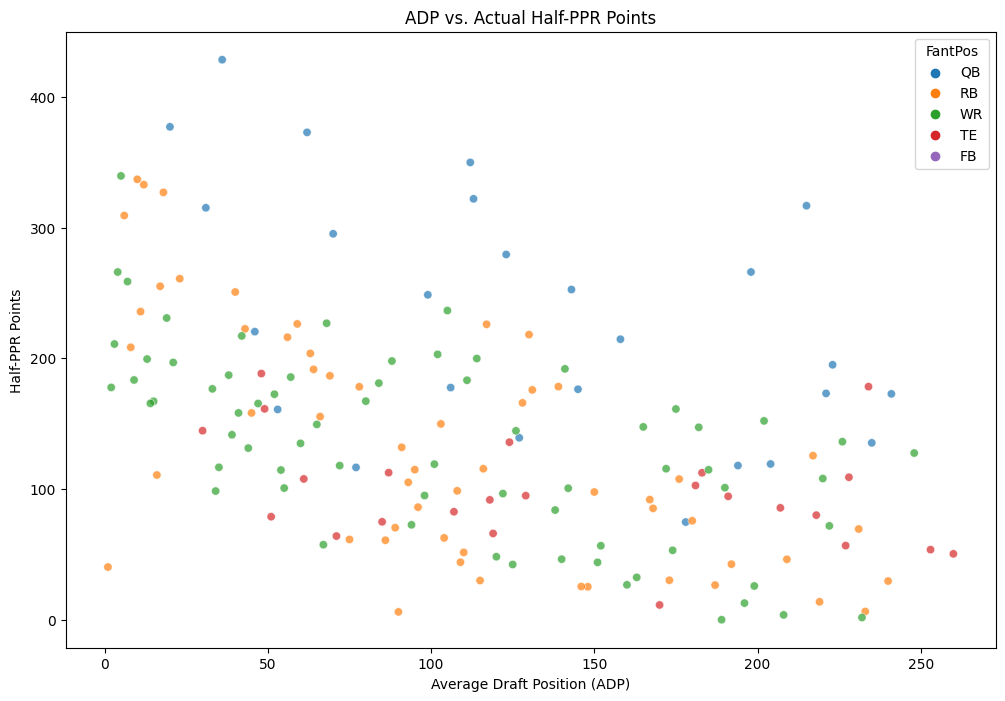

In [18]:
def main():
    """Main function to execute the data preparation workflow."""
    # Set pandas display options
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_rows', 100)
    
    # 1. Load configuration
    config, raw_data_path, processed_data_path, season = load_configuration()
    
    # 2. Check data files
    expected_files = check_data_files(raw_data_path)
    
    # 3. Load data files
    data_dict = load_and_examine_data(config)
    
    # 4. Examine key datasets
    examine_preseason_rankings(data_dict)
    examine_season_data(data_dict, season)
    examine_passing_data(data_dict, season)
    examine_team_stats(data_dict, season)
    
    # 5. Standardize team names
    data_dict = standardize_team_names_across_datasets(data_dict)
    
    # 6. Filter for target season
    filtered_data_dict = filter_for_target_season(data_dict, season)
    
    # 7. Create master dataset
    master_df = create_and_examine_master_dataset(filtered_data_dict)
    
    # 8. Calculate fantasy points
    master_df = calculate_and_examine_fantasy_points(master_df)
    
    # 9. Compare pre-season rankings with actual performance
    master_df = compare_preseason_and_actual(master_df)
    
    # 10. Save processed datasets
    save_processed_datasets(master_df, filtered_data_dict, processed_data_path)
    
    # 11. Print summary and next steps
    print_summary_and_next_steps(master_df, data_dict, season)

if __name__ == "__main__":
    main()